# Index Tracking with Gurobi

This Python notebook is part of the webinar [Proven Techniques for Solving Financial Problems with Gurobi](https://www.gurobi.com/events/proven-techniques-for-solving-financial-problems-with-gurobi/).

The sequence of python code will:
1. Import stock data from yahoo finance
2. Clean up the data and change format
3. Perform an index tracking experiment

## Importing Data from YFinance

- Adjusted Stock price data for SP100 constitutents 
- Data from 2010 to 2022

In [1]:
from utils.data_import import get_sp100

# Options
FIRST_DATE  = "2020-01-01"
LAST_DATE   = "2025-01-01"
N_PROCESSES = 10
MKT_INDEX   = "^SP100"

df_prices = get_sp100(FIRST_DATE,LAST_DATE)

df_prices.head()

Fetching SP100 components
	-> got 101 tickers



c:\Users\joaov\Documents\bootcamp-ds-4ed\utils\data_import.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=FIRST_DATE, end=LAST_DATE)["Close"]
[*********************100%***********************]  102 of 102 completed

1 Failed download:
['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')


Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM,^SP100
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,72.538513,69.823479,78.208038,192.515015,334.429993,44.517933,49.099998,201.031097,195.522324,94.900497,...,267.026428,160.492813,93.547066,46.150043,183.549057,43.349491,46.294521,36.508110,54.131069,1458.130005
2020-01-03,71.833290,69.160690,77.254623,192.194427,331.809998,44.173916,48.599998,199.666321,195.616455,93.748497,...,264.324188,159.356934,93.490990,45.612137,182.089294,42.887947,46.010296,36.185806,53.695889,1446.479980
2020-01-06,72.405670,69.706520,77.659363,190.939331,333.709991,44.208309,48.389999,201.198563,195.565125,95.143997,...,266.159088,157.992142,93.074478,44.988491,181.695511,42.795643,45.734684,36.112144,54.108173,1452.810059
2020-01-07,72.065132,69.308846,77.227631,186.817001,333.390015,43.958893,48.250000,199.306305,191.397964,95.343002,...,264.552429,156.794662,92.914276,44.559738,181.215332,42.319885,45.355717,35.777576,53.665348,1447.359985
2020-01-08,73.224403,69.800072,77.542442,187.183426,337.869995,44.474937,47.830002,199.457001,193.057999,94.598503,...,270.130280,158.511673,93.442924,44.466179,184.317444,42.398003,45.493523,35.654797,52.856056,1455.489990


## Cleaning and Splitting the Data

In [2]:
from utils.data_clean import clean_data

THRESH_VALID_DATA = 0.95 # defines where to cut stocks with missing data
PERC_SIZE_TRAIN = 0.75   # defines the size of train dataset (in %)

df_ret, df_train, df_test  = clean_data(
    df_prices, 
    thresh_valid_data = THRESH_VALID_DATA,
    size_train = PERC_SIZE_TRAIN
)

In [3]:
import gurobipy as gp
import pandas as pd
import numpy as np
from random import sample, seed

seed(20220209) # reproducibility

mkt_index = "^SP100"
n_assets = 20

# data from main notebook
r_it = df_train

r_mkt = r_it[mkt_index]

r_it = r_it.drop(mkt_index, axis = 1)

tickers = list(r_it.columns)

sampled_tickers = sample(tickers, n_assets)

r_it = r_it[sampled_tickers]

print(r_it.head())

Ticker           RTX       ABT       AMD        MS        MA      ISRG  \
Date                                                                     
2020-01-03  0.001371 -0.012191 -0.010183 -0.016141 -0.009756 -0.006563   
2020-01-06  0.002152  0.005239 -0.004321 -0.003516  0.002663  0.004079   
2020-01-07 -0.003188 -0.005559 -0.002893 -0.001960 -0.003386 -0.021754   
2020-01-08  0.001501  0.004076 -0.008705  0.012765  0.017644 -0.001750   
2020-01-09  0.001499  0.002668  0.023834  0.009502  0.013111  0.006893   

Ticker          SBUX       HON       LLY      MDLZ       PFE       SPG  \
Date                                                                     
2020-01-03 -0.005820 -0.010675 -0.003328 -0.001657 -0.005366  0.001792   
2020-01-06 -0.007880 -0.007548  0.003719 -0.001659 -0.001284  0.005229   
2020-01-07 -0.003064  0.000563  0.001890 -0.004247 -0.003344 -0.011361   
2020-01-08  0.011609  0.000844  0.009056  0.002411  0.008000  0.006577   
2020-01-09  0.018564  0.007370  0.016

## Constrained Index Tracking

$
\begin{array}{llll}
  & \min              & \frac{1}{T} \; \sum_{t = 1}^{T} \left(\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{i,t} - R_{t}\right)^2 \\
  & \text{subject to} &   \sum_{i = 1}^{I} w_{i}  = 1  \\
  &                   &   \sum_{i = 1}^{I} z_{i} \leq K \\
  &                   & w_i \geq 0 \\
  &                   & z_i \in {0, 1}
\end{array}
$

  

$
\begin{array}{lllll}
& where: \\
& \\
& w_i  &: \text{Weight of asset i in index} \\
& z_i &: \text{Binary variable (0, 1) that decides wheter asset i is in portfolio} \\
& R_{t} &: \text{Returns of tracked index (e.g. SP500) at time t} \\
& r_{i,j} &: \text{Return of asset i at time t}
\end{array}
$

In [4]:
# Create an empty model
m = gp.Model('gurobi_index_tracking')

# PARAMETERS 

max_assets = 10

# w_i: the i_th stock gets a weight w_i
w = pd.Series(m.addVars(sampled_tickers, 
                         lb = 0,
                         ub = 0.2,
                         vtype = gp.GRB.CONTINUOUS), 
               index=sampled_tickers)

# [NEW] z_i: the i_th stock gets a binary z_i
z = pd.Series(m.addVars(sampled_tickers,
                        vtype = gp.GRB.BINARY),
                index=sampled_tickers)

# CONSTRAINTS

# sum(w_i) = 1: portfolio budget constrain (long only)
m.addConstr(w.sum() == 1, 'port_budget')

# [NEW]  w_i <= z_i: restrictions of values of w_i so take it chose particular tickers
for i_ticker in sampled_tickers:
    m.addConstr(w[i_ticker] <= z[i_ticker], 
                f'dummy_restriction_{i_ticker}')

# [NEW] sum(z_i) <= max_assets: number of assets constraint
m.addConstr(z.sum() <= max_assets, 'max_assets_restriction')

m.update()

# eps_t = R_{i,t}*w - R_{M,t}
my_error = r_it.dot(w) - r_mkt

# set objective function
m.setObjective(
    gp.quicksum(my_error.pow(2)), 
    gp.GRB.MINIMIZE)     

# Optimize model
m.setParam('OutputFlag', 0)
m.setParam('TimeLimit', 60*5) # in secs
#m.setParam('MIPGap', 0.05) # in secs
m.optimize()

params = [i.X for i in m.getVars()]

n_assets = len(sampled_tickers)
w_hat = params[0:n_assets]
z_hat = params[n_assets:]
MIPGap = m.getAttr('MIPGap')
status = m.getAttr("Status")

print(f"Solution for w:") 

for i, i_ticker in enumerate(sampled_tickers):
    print(f"{i_ticker}:\t {w_hat[i]*100:.2f}%")

# check constraints
print(f"\nchecking constraints:")
print(f"sum(w) = {np.sum(w_hat)}")
print(f"sum(z) = {np.sum(z_hat)}")
print(f"w <= z = {w_hat <= z_hat}")
print(f"MIPGap={MIPGap}")
print(f"Status={status}")

Restricted license - for non-production use only - expires 2026-11-23
Solution for w:
RTX:	 0.00%
ABT:	 7.96%
AMD:	 5.50%
MS:	 0.00%
MA:	 9.57%
ISRG:	 0.00%
SBUX:	 0.00%
HON:	 0.00%
LLY:	 6.82%
MDLZ:	 15.76%
PFE:	 0.00%
SPG:	 0.00%
UBER:	 0.00%
GE:	 0.00%
MO:	 7.79%
AVGO:	 11.01%
BLK:	 7.07%
INTC:	 0.00%
GOOGL:	 20.00%
BAC:	 8.53%

checking constraints:
sum(w) = 1.0
sum(z) = 10.0
w <= z = True
MIPGap=0.0
Status=2


Index(['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMD', 'AMGN', 'AMT',
       'AMZN',
       ...
       'UNH', 'UNP', 'UPS', 'USB', 'V', 'VZ', 'WFC', 'WMT', 'XOM', '^SP100'],
      dtype='object', name='Ticker', length=101)
['RTX', 'ABT', 'AMD', 'MS', 'MA', 'ISRG', 'SBUX', 'HON', 'LLY', 'MDLZ', 'PFE', 'SPG', 'UBER', 'GE', 'MO', 'AVGO', 'BLK', 'INTC', 'GOOGL', 'BAC']


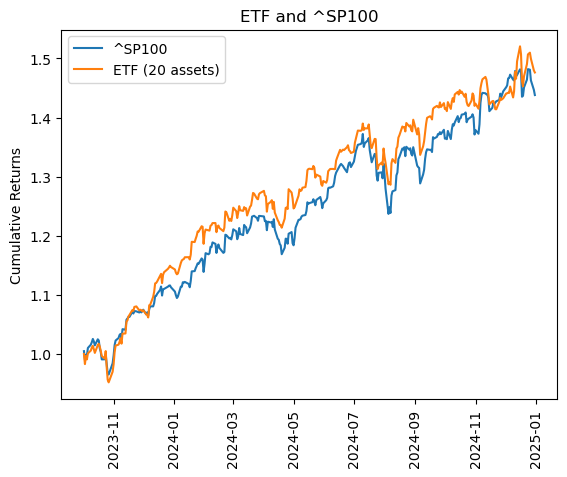

In [5]:
# check out of sample plot
import matplotlib.pyplot as plt

df_test = df_test

print(df_test.columns)
print(sampled_tickers)
df_test_mkt = df_test[mkt_index]

r_hat = df_test[sampled_tickers].dot(w_hat)

cumret_r = np.cumprod(1+ r_hat)
cumret_mkt = np.cumprod(1+ df_test_mkt)

fig, ax = plt.subplots()
ax.plot(cumret_mkt.index,
        cumret_mkt, 
       label = mkt_index)

ax.plot(cumret_r.index,
        cumret_r,
       label = f"ETF ({n_assets} assets)")

ax.legend()
ax.set_title(f'ETF and {mkt_index}')
ax.set_xlabel('')
ax.set_ylabel('Cumulative Returns')

plt.xticks(rotation = 90)

plt.show()